Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 0: Error = 0.16338196151171386
Epoch 12000: Error = 0.004206328744892018
Epoch 24000: Error = 0.0024282720994123637
Epoch 36000: Error = 0.002389352123683597
Epoch 48000: Error = 0.0023899285347805444
Epoch 60000: Error = 0.002388413121853109
Epoch 72000: Error = 0.002386767015070592
Epoch 84000: Error = 0.002385296215538127
Epoch 96000: Error = 0.002383975585968263
Epoch 108000: Error = 0.0023827626380066975


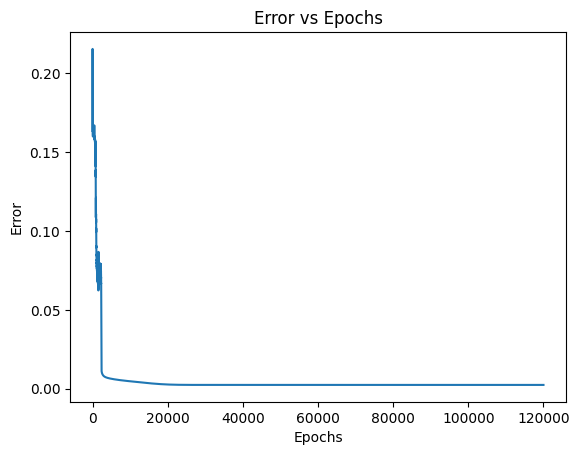

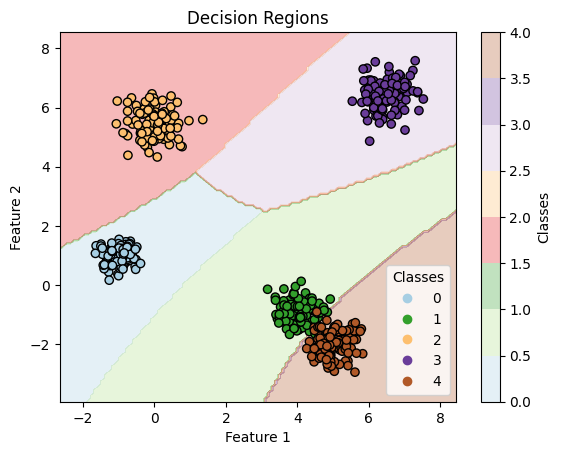

In [3]:
# Mount Google Drive (skip if already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
file_path = '/content/drive/MyDrive/five_class_data_v3.csv'
syndata = pd.read_csv(file_path)

# Features and One-hot encoded class labels
Feature = syndata[['X', 'Y']].values
Class = syndata['Class'].values
New_class = pd.get_dummies(Class).values  # Ensure this results in shape (n_samples, 5)

# Verify class count
num_classes = New_class.shape[1]

# Neural Network Class
class NeuralNetwork:
    def __init__(self, num_outputs):
        self.input_neurons = 2
        self.hidden1_neurons = 6
        self.hidden2_neurons = 4
        self.hidden3_neurons = 5
        self.output_neurons = num_outputs
        self.lr = 0.03

        self.W_input_hidden1 = np.random.randn(self.input_neurons, self.hidden1_neurons) * 0.1
        self.W_hidden1_hidden2 = np.random.randn(self.hidden1_neurons, self.hidden2_neurons) * 0.1
        self.W_hidden2_hidden3 = np.random.randn(self.hidden2_neurons, self.hidden3_neurons) * 0.1
        self.W_hidden3_output = np.random.randn(self.hidden3_neurons, self.output_neurons) * 0.1

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, sig):
        return sig * (1 - sig)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        self.Z1 = np.dot(X, self.W_input_hidden1)
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = np.dot(self.A1, self.W_hidden1_hidden2)
        self.A2 = self.sigmoid(self.Z2)
        self.Z3 = np.dot(self.A2, self.W_hidden2_hidden3)
        self.A3 = self.sigmoid(self.Z3)
        self.Z_out = np.dot(self.A3, self.W_hidden3_output)
        self.A_out = self.softmax(self.Z_out)
        return self.A_out

    def backward(self, X, y, predictions):
        error_out = y - predictions
        delta_out = error_out * self.lr

        error_hidden3 = np.dot(delta_out, self.W_hidden3_output.T)
        delta_hidden3 = error_hidden3 * self.sigmoid_derivative(self.A3) * self.lr

        error_hidden2 = np.dot(delta_hidden3, self.W_hidden2_hidden3.T)
        delta_hidden2 = error_hidden2 * self.sigmoid_derivative(self.A2) * self.lr

        error_hidden1 = np.dot(delta_hidden2, self.W_hidden1_hidden2.T)
        delta_hidden1 = error_hidden1 * self.sigmoid_derivative(self.A1) * self.lr

        self.W_hidden3_output += np.dot(self.A3.T, delta_out)
        self.W_hidden2_hidden3 += np.dot(self.A2.T, delta_hidden3)
        self.W_hidden1_hidden2 += np.dot(self.A1.T, delta_hidden2)
        self.W_input_hidden1 += np.dot(X.T, delta_hidden1)

    def train(self, input, target):
        output = self.forward(input)
        self.backward(input, target, output)

    def MeanSerr(self, input, target):
        predictions = self.forward(input)
        return np.mean(np.square(target - predictions))

# Train model
a = NeuralNetwork(num_outputs=num_classes)
errors = []

for i in range(120000):
    a.train(Feature, New_class)
    error = a.MeanSerr(Feature, New_class)
    errors.append(error)
    if i % 12000 == 0:
        print(f"Epoch {i}: Error = {error}")

# Plot error
plt.plot(errors)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error vs Epochs')
plt.show()

# Decision Region Plot
x_min, x_max = Feature[:, 0].min() - 1, Feature[:, 0].max() + 1
y_min, y_max = Feature[:, 1].min() - 1, Feature[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

grid_points = np.c_[xx.ravel(), yy.ravel()]
predictions = a.forward(grid_points)
predicted_classes = np.argmax(predictions, axis=1)
Z = predicted_classes.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.colorbar(label="Classes")
scatter = plt.scatter(Feature[:, 0], Feature[:, 1], c=np.argmax(New_class, axis=1),
                      cmap=plt.cm.Paired, edgecolor='k')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Regions')
plt.show()
